<a href="https://colab.research.google.com/github/matsunagalab/ColabBTR/blob/main/ColabBTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ColabBTR: Blind tip reconstruction on Google Colab

Easy to use notebook for using end-to-end differentiable blind tip reconstruction and removing the tip convoution artifacts from you AFM data.

*   This notebook can read and write several file formats of AFM data
*   Perform end-to-end differentiable blind tip reconsruction to reconstruct tip shape only from AFM data
*   Perform erosion (deconvoulution) with the reconstructed tip to remove tip convolution artifacts


[Y. Matsunaga, S. Fuchigami, T. Ogane, S. Takada. End-to-end differentiable blind tip reconstruction for noisy atomic force microscopy images.
*Scientific Reports*, 2023](https://www.nature.com/articles/s41598-022-27057-2)

In [1]:
#@title Install dependencies
%%time
import os

print("installing colabbtr...")
os.system("pip install -q --no-warn-conflicts git+https://github.com/matsunagalab/ColabBTR.git@develop")

print("installing libasd...")
os.system("pip install -q --no-warn-conflicts libasd")

print("upgrading gdown...")
os.system("pip install -q --upgrade --no-warn-conflicts gdown")

print("installing spmpy...")
os.system("pip install -q --no-warn-conflicts git+https://github.com/kogens/spmpy")

print("installing gwyfile...")
os.system("pip install -q --no-warn-conflicts gwyfile")

print("✨All installation completed!✨")


installing colabbtr...
installing libasd...
upgrading gdown...
installing spmpy...
installing gwyfile...
✨All installation completed!✨
CPU times: user 401 ms, sys: 46.5 ms, total: 448 ms
Wall time: 1min 43s


In [2]:
#@title Upload AFM data (asd, gwy, spm, npy, npz, csv files are supported)
#@markdown Click the button that appears below this cell to upload your AFM file.
from google.colab import files
import os
import re
import hashlib
import random

resolution_x = 1
resolution_y = 1

#@markdown - **Jobname**: used for name of job or directory<br>
#@markdown example: 0
jobname = 'test' #@param {type:"string"}
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)

custom_path = os.path.join(jobname,f"afm_data")
os.makedirs(custom_path, exist_ok=True)
uploaded = files.upload()
for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_path,fn))

print("jobname",jobname)
print("custom_path",custom_path)
print(uploaded.keys())

Saving images.npy to images.npy
jobname test
custom_path test/afm_data
dict_keys(['images.npy'])


In [3]:
#@title Load the uploaded data
import torch
import libasd
import numpy as np
import matplotlib.pyplot as plt
import gwyfile

#@markdown - **Channel number** (option for 2ch *.asd* file)<br>
#@markdown example: 0
channel_number_in_asd = 0#@param {type:"raw"}
#@markdown - **Name of channels** (option for *.gwy* file)<br>
#@markdown example: topography
channel_name_in_gwyfile = "topography"#@param {type:"string"}

# Save parameter file
custom_path = os.path.join('/content', jobname, f'afm_data')
#with open(f'{custom_path}/upload_file_params.txt', 'w') as f:
#  f.write(f'channel_number_in_asd: {channel_number_in_asd}\n')
#  f.write(f'channel_name_in_gwyfilee: {channel_name_in_gwyfile}\n')

file_path = []
for filename in os.listdir(custom_path):
    file_path.append(os.path.join(custom_path, filename))

if file_path[0].endswith('.asd'):
    data = libasd.read_asd(file_path[0])
    print("version    = {}"     .format(data.header.file_version))
    if len(data.channels) == 1:
        channel = data.channels[0]
        nframe = len(data.frames)
        images = np.zeros((nframe, data.header.y_pixel, data.header.x_pixel))
        for iframe in range(nframe):
            images[iframe, :, :] = data.frames[iframe].image()
    elif len(data.channels) == 2:
        nframe = len(data.channels[channel_number_in_asd])
        images = np.zeros((nframe, data.header.y_pixel, data.header.x_pixel))
        for iframe in range(nframe):
            images[iframe, :, :] = data.channels[channel_number_in_asd][iframe].image()
    else:
        print("too many channels")

elif file_path[0].endswith('.gwy'):
    obj = gwyfile.load(file_path[0])
    channels = gwyfile.util.get_datafields(obj)
    channel = channels[channel_name_in_gwyfile]
    data = channel.data
    images = np.zeros((1, data.shape[0], data.shape[1]))
    images[0, :, :] = data

elif file_path[0].endswith('.npy'):
    images = np.load(file_path[0])

elif file_path[0].endswith('.npz'):
    images = np.load(file_path[0])

else:
    print("unsupported file type")

# create tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = torch.tensor(images, dtype=torch.float32, device=device)
nframe = images.shape[0]

# display information
print("pixel height  = ",images.shape[1])
print("pixel width   =  ",images.shape[2])
print("there are {} frames.".format(images.shape[0]))

pixel height  =  30
pixel width   =   30
there are 576 frames.


In [4]:
#@title Check the filepath
print('filepath:', file_path)

filepath: ['/content/test/afm_data/images.npy']


IntSlider(value=0, description='Frame:', layout=Layout(width='80%'), max=575)

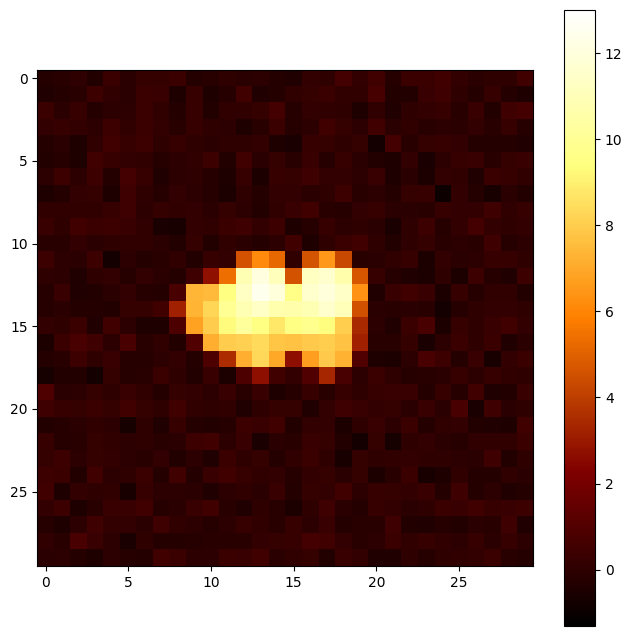

In [5]:
#@title Visualize the data

import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.animation import PillowWriter
from tqdm.notebook import tqdm

#@markdown - **Output frame range**
first_frame = 0#@param {type:"raw"}
nframe = images.shape[0]
last_frame = nframe#@param {type:"raw"}
#@markdown - **Colormap range**
vmin = images.min().item()#@param {type:"raw"}
vmax = images.max().item()#@param {type:"raw"}
#@markdown - **Output image size**
figsize = 8#@param {type:"raw"}
#@markdown - **Movie settings**
save_movie = False #@param {type:"boolean"}
stride = 1#@param {type:"raw"}
frame_per_second = 5#@param {type:"raw"}

# Save parameter file
custom_path = os.path.join('/content', jobname, f'afm_data')
with open(f'{custom_path}/visualize_input_params.txt', 'w') as f:
  f.write(f'first_frame: {first_frame}\n')
  f.write(f'last_frame: {last_frame}\n')
  f.write(f'vmin: {vmin}\n')
  f.write(f'vmax: {vmax}\n')
  f.write(f'figsize: {figsize}\n')
  f.write(f'save_movie: {save_movie}\n')
  f.write(f'stride: {stride}\n')
  f.write(f'frame_per_second: {frame_per_second}\n')

# Save gif
if save_movie:
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    images_sub = images[first_frame:last_frame, :, :].to('cpu').numpy()
    def plot_image(i):
        im = ax.imshow(images_sub[i, :, :],
                        vmin=vmin, vmax=vmax, interpolation='none', origin='upper',
                        cmap="afmhot", aspect="equal")
        ax.set_title(f'Frame {first_frame+i+1}')
    interval = 1 / frame_per_second * 1000
    ani = animation.FuncAnimation(fig, plot_image, interval=interval, frames=tqdm(np.arange(0, len(images_sub), stride), position=0, leave=False))
    writer = PillowWriter(fps=frame_per_second)
    ani.save(f'{custom_path}/input.gif', writer=writer)
    plt.close()

# 初期のプロットを作成
fig, ax = plt.subplots(figsize=(figsize, figsize))
image = ax.imshow(images[first_frame, :, :].to('cpu').numpy(),
                    vmin=vmin, vmax=vmax, interpolation='none', origin='upper',
                    cmap="afmhot", aspect="equal")

# show colorbar
fig.colorbar(image, ax=ax)

# スライダーの作成
#slider = widgets.IntSlider(value=0, min=0, max=nframe, step=1, description='Slider:')
# スライダーの作成（幅を調整）
slider = widgets.IntSlider(value=0, min=first_frame, max=last_frame-1, step=1, description='Frame:',
                        layout=widgets.Layout(width='80%'))

# イベントハンドラーの定義
def on_value_change(change):
    # 画像データを更新
    new_data = images[change['new'], :, :].to('cpu').numpy()
    image.set_data(new_data)

    # プロットをクリアして再描画
    clear_output(wait=True)
    display(slider)
    display(fig)

# スライダーにイベントハンドラーを関連付ける
slider.observe(on_value_change, names='value')
# スライダーとプロットを表示
display(slider)


IntSlider(value=139, description='Frame:', layout=Layout(width='80%'), max=575)

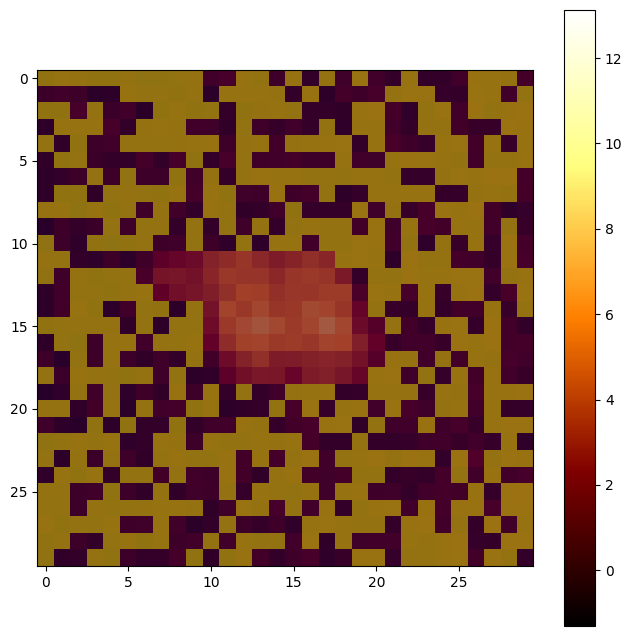

In [6]:
#@title (Optional) Correct stage tilt by RANSAC

import torch
import numpy as np
from sklearn.linear_model import RANSACRegressor
import ipywidgets as widgets
import matplotlib.pyplot as plt

custom_path = os.path.join('/content', jobname, f'stage_tilt')
os.makedirs(custom_path, exist_ok=True)

def correct_afm_tilt_multi_frame(images):
    np_images = images.cpu().numpy()

    # Create (x, y, z) coordinates for all frames combined
    nframes, height, width = np_images.shape
    y_grid, x_grid = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    coordinates = np.stack([np.repeat(x_grid.ravel(), nframes),
                            np.repeat(y_grid.ravel(), nframes),
                            np_images.reshape(-1)], axis=1)

    # Perform plane fitting using RANSAC for all frames combined
    ransac = RANSACRegressor()
    ransac.fit(coordinates[:, :2], coordinates[:, 2])

    # Get parameters of the plane (ax + by + c = z)
    a, b = ransac.estimator_.coef_
    c = ransac.estimator_.intercept_

    # Calculate corrected heights for all frames
    corrected_images = np_images - (a * x_grid + b * y_grid + c)

    # Identify inliers and outliers for all frames
    inlier_mask = ransac.inlier_mask_.reshape(nframes, height, width)

    # Convert corrected_images and inlier_mask back to PyTorch tensors with the same precision and device as input
    corrected_images_tensor = torch.tensor(corrected_images, dtype=images.dtype, device=images.device)
    inlier_mask_tensor = torch.tensor(inlier_mask, dtype=torch.bool, device=images.device)

    return corrected_images_tensor, inlier_mask_tensor

# Assuming `corrected_heights` and `inlier_mask` are obtained from the above function
corrected_images, inlier_mask = correct_afm_tilt_multi_frame(images)
np.save(f'{custom_path}/corrected_images', corrected_images.cpu().numpy())
np.save(f'{custom_path}/inlier_mask', inlier_mask.cpu().numpy())

images = corrected_images
#@markdown - **Frame range**: for visualization
first_frame = 0#@param {type:"raw"}
last_frame = nframe#@param {type:"raw"}
#@markdown - **Colormap range**
vmin = images.min().item()#@param {type:"raw"}
vmax = images.max().item()#@param {type:"raw"}
#@markdown - **Output image size**
figsize = 8#@param {type:"raw"}
#@markdown - **Movie settings**
save_movie = False #@param {type:"boolean"}
stride = 1#@param {type:"raw"}
frame_per_second = 5#@param {type:"raw"}

# Save parameter file
with open(f'{custom_path}/stage_tilt_params.txt', 'w') as f:
  f.write(f'first_frame: {first_frame}\n')
  f.write(f'last_frame: {last_frame}\n')
  f.write(f'vmin: {vmin}\n')
  f.write(f'vmax: {vmax}\n')
  f.write(f'figsize: {figsize}\n')
  f.write(f'save_movie: {save_movie}\n')
  f.write(f'stride: {stride}\n')
  f.write(f'frame_per_second: {frame_per_second}\n')

# Save gif
if save_movie:
    fig_ransac, ax_ransac = plt.subplots(figsize=(figsize, figsize))
    def plot_ransac(i):
        ax_ransac.imshow(images[i, :, :].to('cpu').numpy(),
                  vmin=vmin, vmax=vmax, interpolation='none', origin='upper',
                  cmap="afmhot", aspect="equal")
        ax_ransac.imshow(inlier_mask[i].cpu().numpy(), alpha=0.5,
                  vmin=0, vmax=1,  interpolation='none', origin='upper',
                  cmap="viridis", aspect="equal")
        ax_ransac.set_title(f'Frame {i+1}')
    interval = 1 / frame_per_second * 1000
    ani = animation.FuncAnimation(fig_ransac, plot_ransac, interval=interval, frames=tqdm(np.arange(first_frame, last_frame, stride), position=0, leave=False))
    writer = PillowWriter(fps=frame_per_second)
    ani.save(f'{custom_path}/ransac.gif', writer=writer)
    plt.close()

fig_ransac, ax_ransac = plt.subplots(figsize=(figsize, figsize))
image_ransac = ax_ransac.imshow(images[first_frame, :, :].to('cpu').numpy(),
                   vmin=vmin, vmax=vmax, interpolation='none', origin='upper',
                   cmap="afmhot", aspect="equal")
ax_ransac.imshow(inlier_mask[first_frame].cpu().numpy(), alpha=0.5,
               vmin=0, vmax=1,  interpolation='none', origin='upper',
               cmap="viridis", aspect="equal")

# show colorbar
fig_ransac.colorbar(image_ransac, ax=ax_ransac)

# スライダーの作成
#slider = widgets.IntSlider(value=0, min=0, max=nframe, step=1, description='Slider:')
# スライダーの作成（幅を調整）
slider_ransac = widgets.IntSlider(value=0, min=first_frame, max=last_frame-1, step=1, description='Frame:',
                       layout=widgets.Layout(width='80%'))

# イベントハンドラーの定義
def on_value_change_ransac(change):
    # 画像データを更新
    #new_data = images[change['new'], :, :].to('cpu').numpy()
    #image.set_data(new_data)
    ax_ransac.imshow(images[change['new'], :, :].to('cpu').numpy(),
               vmin=vmin, vmax=vmax, interpolation='none', origin='upper',
               cmap="afmhot", aspect="equal")
    ax_ransac.imshow(inlier_mask[change['new']].cpu().numpy(), alpha=0.5,
               vmin=0, vmax=1,  interpolation='none', origin='upper',
               cmap="viridis", aspect="equal")

    # プロットをクリアして再描画
    clear_output(wait=True)
    display(slider_ransac)
    display(fig_ransac)

# スライダーにイベントハンドラーを関連付ける
slider_ransac.observe(on_value_change_ransac, names='value')
# スライダーとプロットを表示
display(slider_ransac)

In [ ]:
#@title Working in progress... (Optional) Determine optimal weight decay for AdamW by cross-validation


  0%|          | 0/100 [00:00<?, ?it/s]

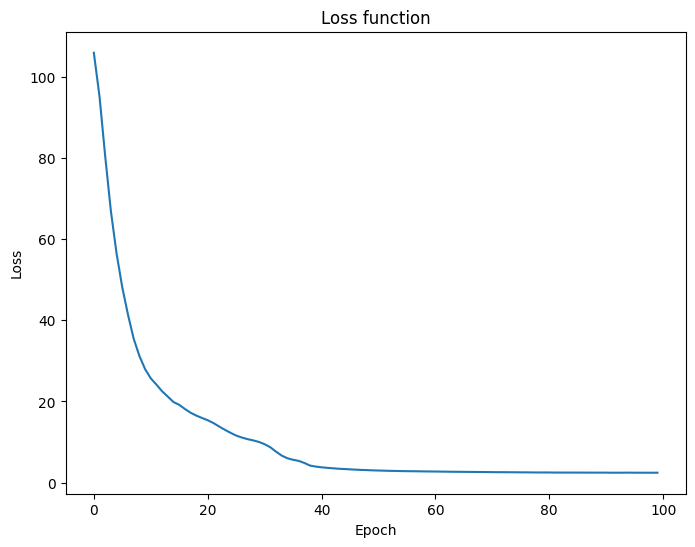

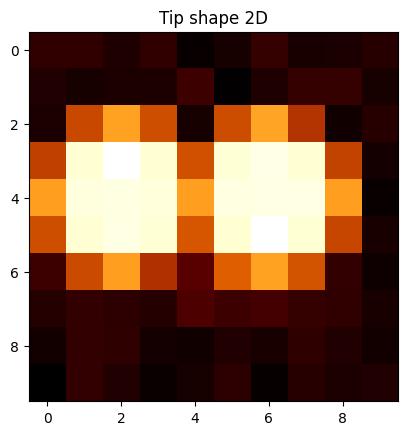

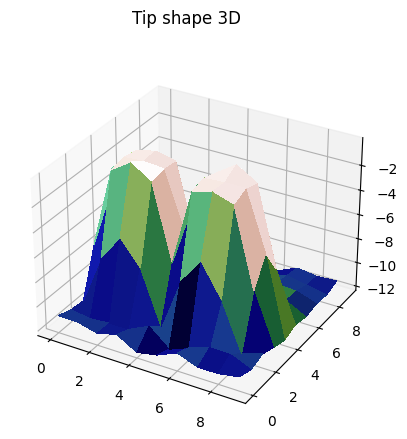

CPU times: user 11.4 s, sys: 825 ms, total: 12.3 s
Wall time: 13.1 s


In [7]:
#@title Run the end-to-end differentiable BTR and reconstruct tip shape from AFM images

%%time
from colabbtr.morphology import differentiable_btr

custom_path = os.path.join('/content', jobname, f'differentiable_BTR')
os.makedirs(custom_path, exist_ok=True)

#@markdown - **Frame range**: used for estimation of tip shape
first_frame = 0#@param {type:"raw"}
last_frame = 30#@param {type:"raw"}
#@markdown - **Tip size**: used for tip height and width
tip_size = 10#@param {type:"raw"}
tip_height = tip_size
tip_width = tip_size
#@markdown - **Settings for learning**
epoch = 100#@param {type:"raw"}
learning_rate = 0.1#@param {type:"raw"}
weight_decay = 0.0#@param {type:"raw"}

# Save parameter file
with open(f'{custom_path}/differentiable_BTR_params.txt', 'w') as f:
  f.write(f'first_frame: {first_frame}\n')
  f.write(f'last_frame: {last_frame}\n')
  f.write(f'tip_size: {tip_size}\n')
  f.write(f'epoch: {epoch}\n')
  f.write(f'learning_rate: {learning_rate}\n')
  f.write(f'weight_decay: {weight_decay}\n')

tip, loss = differentiable_btr(images[first_frame:last_frame, :, :],
                             (tip_height, tip_width),
                             nepoch=epoch, lr=learning_rate, weight_decay=weight_decay)
np.save(f'{custom_path}/tip', tip.to('cpu').numpy())
np.save(f'{custom_path}/loss', loss)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LightSource
from matplotlib import cm

plt.figure(figsize=(8, 6))

plt.title('Loss function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss)
plt.savefig(f'{custom_path}/differentiable_BTR_loss.png')
plt.show()

plt.title('Tip shape 2D')
plt.imshow(tip.to('cpu').numpy(), cmap="afmhot", aspect="equal")
plt.savefig(f'{custom_path}/tip_shape_2D.png')
plt.show()
#plt.imshow(idilation(surface_tensor, tip_tensor).cpu().detach().numpy(), cmap='afmhot')

nrows, ncols = tip.shape
# xとyの範囲を生成
x = np.arange(ncols)
y = np.arange(nrows)
x, y = np.meshgrid(x, y)
# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
fig.suptitle('Tip shape 3D')
ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(tip.to('cpu').numpy(), cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, tip.to('cpu').numpy(), rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)
plt.savefig(f'{custom_path}/tip_shape_3D.png')
plt.show()


In [8]:
#@title (Optional) Visualize tip shape in 3D
#@markdown Visualize 3D tip shape interactively.

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "colab"

fig = go.Figure(data=[go.Surface(z=tip.to('cpu').numpy())])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Tip shape', autosize=False,
                  width=600, height=500,
                  margin=dict(l=65, r=50, b=65, t=50))

fig.show()

IntSlider(value=0, description='Frame:', layout=Layout(width='80%'), max=29)

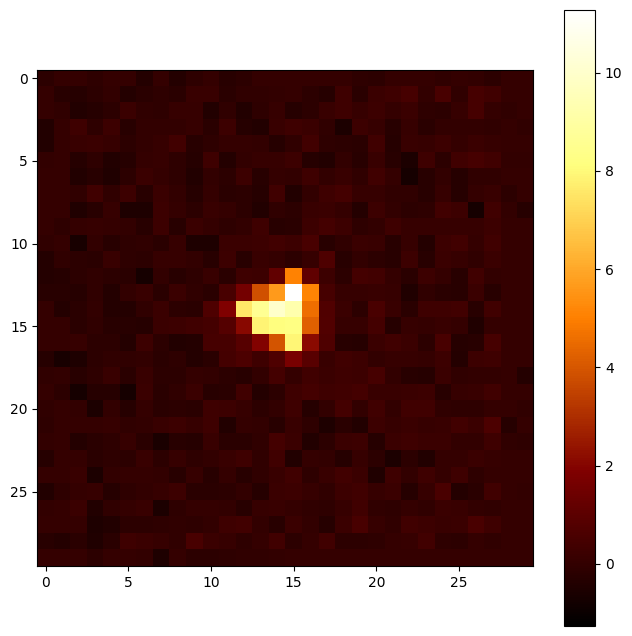

In [9]:
#@title Run erosion (deconvolution) with the reconstructed tip
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from colabbtr.morphology import ierosion

custom_path = os.path.join('/content', jobname, f'erosion')
os.makedirs(custom_path, exist_ok=True)

surface = torch.zeros_like(images, device=device)
for iframe in range(nframe):
    surface[iframe, :, :] = ierosion(images[iframe, :, :], tip)

np.save(f'{custom_path}/surface', surface.to('cpu').numpy())

#@markdown - **Frame range**: used for erosion
#images_or_movie = 'images' #@param ["images", "movie"] {allow-input: true}
first_frame = 0#@param {type:"raw"}
nframe = images.shape[0]
last_frame = 30#@param {type:"raw"}
# frame_per_second = 5#@param {type:"raw"}
#@markdown - **Colormap range**
vmin = surface.min().item()#@param {type:"raw"}
vmax = surface.max().item()#@param {type:"raw"}
#@markdown - **Output image size**
figsize = 8#@param {type:"raw"}
#@markdown - **Movie settings**
save_movie = False #@param {type:"boolean"}
stride = 1#@param {type:"raw"}
frame_per_second = 5#@param {type:"raw"}

# Save parameter file
with open(f'{custom_path}/erosion_params.txt', 'w') as f:
  f.write(f'first_frame: {first_frame}\n')
  f.write(f'last_frame: {last_frame}\n')
  f.write(f'vmin: {vmin}\n')
  f.write(f'vmax: {vmax}\n')
  f.write(f'figsize: {figsize}\n')
  f.write(f'save_movie: {save_movie}\n')
  f.write(f'stride: {stride}\n')
  f.write(f'frame_per_second: {frame_per_second}\n')

# Save gif
if save_movie:
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    def plot_surface(i):
        im = ax.imshow(surface[i, :, :].to('cpu').numpy(),
                        vmin=vmin, vmax=vmax, interpolation='none', origin='upper',
                        cmap="afmhot", aspect="equal")
        ax.set_title(f'Frame {i+1}')
    interval = 1 / frame_per_second * 1000
    ani = animation.FuncAnimation(fig, plot_surface, interval=interval, frames=tqdm(np.arange(first_frame, last_frame, stride), position=0, leave=False))
    writer = PillowWriter(fps=frame_per_second)
    ani.save(f'{custom_path}/erosion.gif', writer=writer)
    plt.close()

# 初期のプロットを作成
fig, ax = plt.subplots(figsize=(figsize, figsize))
image = ax.imshow(surface[first_frame, :, :].to('cpu').numpy(),
                    vmin=vmin, vmax=vmax, interpolation='none', origin='upper',
                    cmap="afmhot", aspect="equal")

# show colorbar
fig.colorbar(image, ax=ax)

# スライダーの作成
#slider = widgets.IntSlider(value=0, min=0, max=nframe, step=1, description='Slider:')
# スライダーの作成（幅を調整）
slider = widgets.IntSlider(value=0, min=first_frame, max=last_frame-1, step=1, description='Frame:',
                         layout=widgets.Layout(width='80%'))

# イベントハンドラーの定義
def on_value_change(change):
    # 画像データを更新
    new_data = surface[change['new'], :, :].to('cpu').numpy()
    image.set_data(new_data)

    # プロットをクリアして再描画
    clear_output(wait=True)
    display(slider)
    display(fig)

# スライダーにイベントハンドラーを関連付ける
slider.observe(on_value_change, names='value')
# スライダーとプロットを表示
display(slider)

In [ ]:
#@title (Optional) Tip shape reconstruction across frames (used for anomaly detection of tip shapes)

from colabbtr.morphology import differentiable_btr
import torch
from tqdm.notebook import tqdm
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np

custom_path = os.path.join('/content', jobname, f'SSIM_score')
os.makedirs(custom_path, exist_ok=True)

# Assuming 'images' is a tensor with shape [nframes, height, width]
#@markdown - **Frame range**
window_frames = 10#@param {type:"raw"}
first_frame = 0#@param {type:"raw"}
nframe = images.shape[0]
last_frame = nframe#@param {type:"raw"}
#@markdown - **Tip size**: used for tip height and width
tip_size = 10#@param {type:"raw"}
tip_height = tip_size
tip_width = tip_size
#@markdown - **Settings for learning**
epoch = 100#@param {type:"raw"}
learning_rate = 0.1#@param {type:"raw"}
weight_decay = 0.0#@param {type:"raw"}

# Save parameter file
with open(f'{custom_path}/SSIM_params.txt', 'w') as f:
  f.write(f'window_frames: {window_frames}\n')
  f.write(f'first_frame: {first_frame}\n')
  f.write(f'last_frame: {last_frame}\n')
  f.write(f'tip_size: {tip_size}\n')
  f.write(f'epoch: {epoch}\n')
  f.write(f'learning_rate: {learning_rate}\n')
  f.write(f'weight_decay: {weight_decay}\n')

# Calculate the number of windows
num_windows = (last_frame - first_frame) - window_frames + 1

# Initialize the tensor to store the tips for each window
tips = torch.zeros((last_frame - first_frame, tip_height, tip_width), device=images.device, dtype=images.dtype)

for i in tqdm(range(first_frame, last_frame)):
    start_frame = i
    end_frame = i + window_frames

    # Extract the frames for the current window
    window_images = images[start_frame:end_frame, :, :]

    # Perform differentiable BTR to estimate the tip shape for the current window
    tip_shape, loss = differentiable_btr(window_images,
                                         (tip_height, tip_width),
                                         nepoch=epoch, lr=learning_rate, weight_decay=weight_decay, is_tqdm=False)

    # Store the estimated tip shape
    tips[i, :, :] = tip_shape

# Function to calculate SSIM for each estimated tip shape against the reference tip shape
def calculate_ssim(tips):
    reference_tip = tips[0].cpu().numpy()
    ssim_scores = [ssim(reference_tip, tip.cpu().numpy(), channel_axis=False) for tip in tips]

    return ssim_scores

# Calculate SSIM scores
ssim_scores = calculate_ssim(tips)
np.save(f'{custom_path}/ssim_scores', ssim_scores)

# Plot SSIM scores
plt.figure(figsize=(10, 5))
plt.plot(ssim_scores, marker='o')
plt.xlabel('Slidig window frame')
plt.ylabel('SSIM with first window tip')
plt.title('SSIM scores of estimated tip shapes across frames')
plt.grid(True)
plt.savefig(f'{custom_path}/SSIM_scores.png')
plt.show()

# Identify frames with potential anomalies based on SSIM threshold
threshold = 0.4  # Example threshold, adjust based on your dataset
anomaly_frames = [i for i, score in enumerate(ssim_scores) if score < threshold]
print("Potential anomaly frames:", anomaly_frames)
with open(f'{custom_path}/SSIM_anomaly_frames.txt', 'w') as f:
  f.write(f'Potential anomaly frames: {anomaly_frames}')

  0%|          | 0/576 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#@title Download results
from google.colab import files
import datetime

with open(f'/content/{jobname}/info.txt', 'w') as f:
  f.write(f'Creation date and time: {datetime.datetime.now()}')

os.system(f"wget -P /content/{jobname} -O /content/{jobname}/LICENSE https://raw.githubusercontent.com/matsunagalab/ColabBTR/main/LICENSE")

# zip圧縮してダウンロード
os.system(f"cd /content")
os.system(f"zip -r {jobname}_result.zip {jobname}")
files.download(f"{jobname}_result.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>